In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import DiadFit as pf
import os

In [2]:

SEM_data=pd.read_excel(os.path.join(os.getcwd(),"S2_SI_Dataset_final.xlsx"),sheet_name="Table S-5. All SEM-EDS",skiprows=[0,2])
Raman_data=pd.read_excel(os.path.join(os.getcwd(),"S2_SI_Dataset_final.xlsx"),sheet_name="TableS-2 All Raman analyses",skiprows=[0,2])

In [3]:
import pandas as pd

# Assuming you have two DataFrames SEM_data and Raman_data
# Merge SEM_data into Raman_data based on the specified columns
merged_df = Raman_data.merge(SEM_data, left_on='FI Name', right_on='EDS_Name', how='left')
merged_df.tail()

,Column headers,py_index,Discarded,filename,Crystal Name,FI Name,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),...,Time,Spot,O,Si,Fe,Mg,Fo,Total,(Mg+Fe)/Si,WD
67,NaN,67,NaN,KS23_316_FIA_50X_rep2,KS23_316,KS23_316_FIA,0.112237,0.006130,0.004797,0.003817,...,0.562500,316_FIA,57.12,14.40,4.60,23.88,0.838483,100.00,0.498599,NaN
68,NaN,68,NaN,KS23_315_FIA_50X,KS23_315,KS23_315_FIA,0.068102,0.004911,0.003098,0.003811,...,0.556944,315_reg1,57.13,14.27,3.50,25.11,0.877665,100.01,0.500788,NaN
69,NaN,69,NaN,KS23_315_FIB_50X,KS23_315,KS23_315_FIB,0.057519,0.004538,0.002443,0.003824,...,0.556944,315_reg1,57.13,14.27,3.50,25.11,0.877665,100.01,0.500788,NaN
70,NaN,70,NaN,KS23_315_FIC_50X,KS23_315,KS23_315_FIC,0.061735,0.004318,0.002016,0.003818,...,0.556944,315_reg1,57.13,14.27,3.50,25.11,0.877665,100.01,0.500788,NaN
71,NaN,71,NaN,KS23_315_FID_50X,KS23_315,KS23_315_FID,0.066167,0.004815,0.002940,0.003813,...,0.559722,315_reg2,57.24,14.29,3.48,24.98,0.877723,99.99,0.497205,NaN


## Calculate SO2 mol %

In [4]:
SO2_molp=pf.calculate_CO2_SO2_ratio(peak_area_SO2=merged_df['Peak_Area_SO2'],
peak_area_diad1=merged_df['Diad1_Voigt_Area'], peak_area_diad2=merged_df['Diad2_Voigt_Area'],
wavelength=532.067, T_K=37+273.15,efficiency_SO2=1, efficiency_CO2=1,
sigma_SO2=4.03, sigma_CO2_v1=0.8, sigma_CO2_v2=1.23).SO2

merged_df['SO2_mol%']=SO2_molp.fillna(0)

merged_df['SO2_mol%'].to_clipboard(excel=True)

In [11]:
import pickle
with open('Ol_T_model.pkl', 'rb') as f:
    poly_pf = pickle.load(f)
merged_df['Temp_from_Fo']=poly_pf(merged_df['Fo'])
# Ones without Fo, fill with Nan
merged_df['Temp_from_Fo']=merged_df['Temp_from_Fo'].fillna(np.nanmean(merged_df['Temp_from_Fo']))

merged_df['P_wFoTemp']=pf.calculate_P_for_rho_T(T_K=merged_df['Temp_from_Fo']+273.15,
                CO2_dens_gcm3=merged_df['Density g/cm3'],
                 EOS='SW96').P_kbar

In [12]:
merged_df['Depth_km_ryanlerner']=pf.convert_pressure_to_depth(P_kbar=merged_df['P_wFoTemp'], model='ryan_lerner')

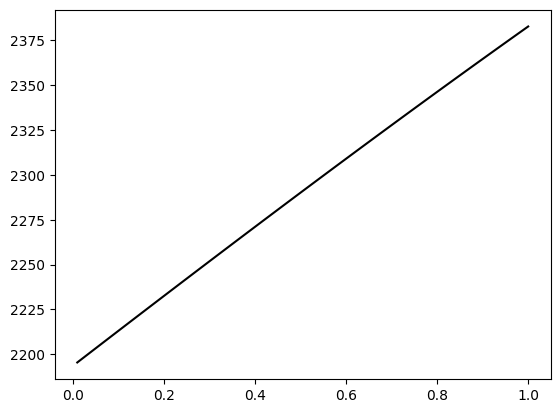

In [13]:
P=np.linspace(0, 1, 100)
D_lerner=pf.convert_pressure_to_depth(P_kbar=P, model='ryan_lerner')
rho_lerner=P/(9.8*D_lerner)
plt.plot(P, rho_lerner*100000, '-k')

We are not using multiprocessing based on your selected EOS. You can override this by setting multiprocess=True in the function, but for SP94 and SW96 it might actually be slower


Processing:   0%|          | 0/72 [00:00<?, ?it/s]

Processing: 100%|██████████| 72/72 [00:04<00:00, 17.19it/s]


,Filename,CO2_dens_gcm3,SingleCalc_D_km,SingleCalc_P_kbar,Mean_MC_P_kbar,Med_MC_P_kbar,std_dev_MC_P_kbar,std_dev_MC_P_kbar_from_percentile,Mean_MC_D_km,Med_MC_D_km,std_dev_MC_D_km,std_dev_MC_D_km_from_percentile,T_K_input,error_T_K,CO2_dens_gcm3_input,error_CO2_dens_gcm3,crust_dens_kgm3_input,error_crust_dens_kgm3,model,EOS
0,K23_10_FIA,0.131039,1.840657,0.415307,0.416473,0.416161,0.015286,0.014575,1.848735,1.845749,0.104367,0.103727,1527.979632,22.663919,0.131039,0.004066,2300,100.0,None,SW96
1,K23_1_FIA,0.144743,2.070597,0.467189,0.466397,0.466717,0.016125,0.015750,2.075349,2.072976,0.117019,0.115188,1539.103462,22.663919,0.144743,0.003971,2300,100.0,None,SW96
2,K23_1_FIA,0.141096,2.012704,0.454126,0.454242,0.453830,0.016311,0.015679,2.015450,2.008465,0.113566,0.109657,1539.103462,22.663919,0.141096,0.003930,2300,100.0,None,SW96
3,K23_2_FIA,0.004106,0.053425,0.012054,0.012052,0.012055,0.000170,0.000177,0.053546,0.053465,0.002499,0.002468,1549.503246,22.663919,0.004106,0.000000,2300,100.0,None,SW96
4,K23_2_FIB,0.063799,0.865259,0.195228,0.196124,0.196076,0.013627,0.012791,0.869773,0.866619,0.072118,0.070884,1549.503246,22.663919,0.063799,0.004039,2300,100.0,None,SW96


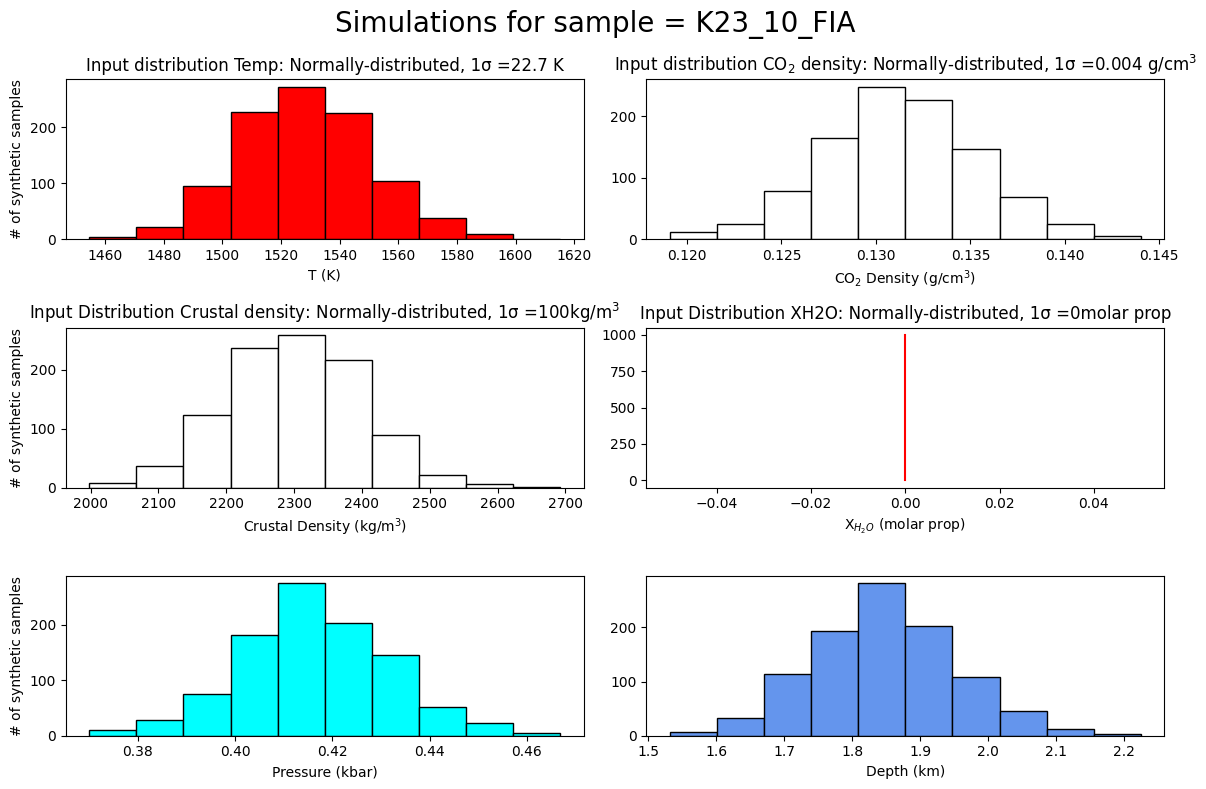

In [14]:
## Lets run a Monte-Carlo simulation to get error on each FI - This uses the Fo content for temperature

MC_Av_rho_T, MC_All_rho_T, fig=pf.propagate_FI_uncertainty(
T_K=merged_df['Temp_from_Fo']+273.15,
error_T_K=np.std(merged_df['Temp_from_Fo']), error_type_T_K='Abs', error_dist_T_K='normal',
CO2_dens_gcm3=merged_df['Density g/cm3'],error_CO2_dens=merged_df['σ Density g/cm3'], error_type_CO2_dens='Abs', error_dist_CO2_dens='normal',
sample_ID=merged_df['FI Name'],

crust_dens_kgm3=2300,
error_crust_dens=100, error_type_crust_dens='Abs', error_dist_crust_dens='normal',
N_dup=1000, fig_i=0, plot_figure=True)
MC_Av_rho_T.head()




In [16]:
# Now merge results into dataframe
full_df=pd.concat([merged_df,MC_Av_rho_T],axis=1)
full_df = full_df.drop(columns=full_df.filter(like='Unnamed'))
display(full_df)

directory=os.path.join(os.getcwd(), 'Notebook_output')
if not os.path.exists(directory):
    os.makedirs(directory)

full_df.to_excel(os.path.join(os.getcwd(),'Notebook_output','mergeddataset_producedbyData_proc_notebook.xlsx'), index=False)

,Column headers,py_index,Discarded,filename,Crystal Name,FI Name,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),...,std_dev_MC_D_km,std_dev_MC_D_km_from_percentile,T_K_input,error_T_K,CO2_dens_gcm3_input,error_CO2_dens_gcm3,crust_dens_kgm3_input,error_crust_dens_kgm3,model,EOS
0,NaN,0,NaN,K23_10_FIA_50X,K23_10,K23_10_FIA,0.131039,0.004066,0.001310,0.003849,...,0.104367,0.103727,1527.979632,22.663919,0.131039,0.004066,2300,100.0,None,SW96
1,NaN,1,NaN,K23_1_FIA_50X,K23_1,K23_1_FIA,0.144743,0.003971,0.000827,0.003884,...,0.117019,0.115188,1539.103462,22.663919,0.144743,0.003971,2300,100.0,None,SW96
2,NaN,2,NaN,K23_1_FIA_50X_r2_longeraq,K23_1,K23_1_FIA,0.141096,0.003930,0.000660,0.003874,...,0.113566,0.109657,1539.103462,22.663919,0.141096,0.003930,2300,100.0,None,SW96
3,NaN,3,NaN,K23_2_FIA_50X,K23_2,K23_2_FIA,0.004106,0.000000,0.000000,0.000000,...,0.002499,0.002468,1549.503246,22.663919,0.004106,0.000000,2300,100.0,None,SW96
4,NaN,4,NaN,K23_2_FIB_50X,K23_2,K23_2_FIB,0.063799,0.004039,0.001325,0.003816,...,0.072118,0.070884,1549.503246,22.663919,0.063799,0.004039,2300,100.0,None,SW96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,NaN,67,NaN,KS23_316_FIA_50X_rep2,KS23_316,KS23_316_FIA,0.112237,0.006130,0.004797,0.003817,...,0.119169,0.119944,1486.035158,22.663919,0.112237,0.006130,2300,100.0,None,SW96
68,NaN,68,NaN,KS23_315_FIA_50X,KS23_315,KS23_315_FIA,0.068102,0.004911,0.003098,0.003811,...,0.082715,0.086028,1560.961691,22.663919,0.068102,0.004911,2300,100.0,None,SW96
69,NaN,69,NaN,KS23_315_FIB_50X,KS23_315,KS23_315_FIB,0.057519,0.004538,0.002443,0.003824,...,0.075611,0.073699,1560.961691,22.663919,0.057519,0.004538,2300,100.0,None,SW96
70,NaN,70,NaN,KS23_315_FIC_50X,KS23_315,KS23_315_FIC,0.061735,0.004318,0.002016,0.003818,...,0.073014,0.069679,1560.961691,22.663919,0.061735,0.004318,2300,100.0,None,SW96
